In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import numpy as np
import matplotlib.pyplot as plt
from pyfrechet.metric_spaces import MetricData, RiemannianManifold, CorrFrobenius, MetricSpace
from geomstats.geometry.hypersphere import Hypersphere
import pandas as pd
from pyfrechet.metric_spaces.correlation.nearcorr import nearcorr
from tqdm import tqdm
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import norm
from scipy import stats
from pyfrechet.metric_spaces import *
import pyfrechet.metric_spaces.wasserstein_1d as W1d

INFO: Using numpy backend
INFO: NumExpr defaulting to 8 threads.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:22: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:54: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matth

0.0

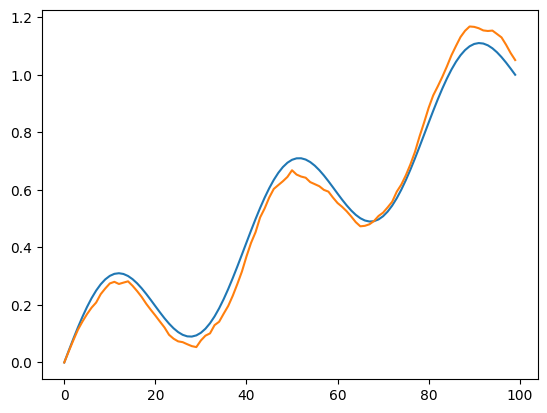

In [197]:
def geodesic(x, theta, mu):
    return theta * x + (1-theta)*mu

def wiener(t, klterms=100):
    terms = (np.arange(1, klterms + 1) + 0.5) * np.pi
    noise = np.random.normal(0, 1, size=klterms)
    return np.sum(noise[:, np.newaxis] * np.sin(terms[:, np.newaxis] * t) / terms[:, np.newaxis], axis=0)

def brownian_bridge(t, klterms=100):
    W_t = wiener(t, klterms)
    return W_t - t * W_t[-1]

def sim(T, phi, mu):
    x = np.zeros((T, mu.shape[0])) + mu
    for i in range(1,T):
        z = geodesic(x[i-1], phi, mu)
        eps = wiener(domain)
        x[i, :] = z + eps
    return x

def phi_hat(x, tol=None):
    from scipy.optimize import minimize
    mu_hat = x.mean(axis=0)
    T = x.shape[0]
    tol = tol or 1.0 / np.sqrt(T)
    def L(phi): return np.array([ np.linalg.norm(x[j+1,:] - geodesic(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
    return minimize(L, np.random.rand(), method='Nelder-Mead', bounds=[(0,1)], options=dict(xatol=tol))['x'][0]

T = 100
phi = 0.1

domain = np.linspace(0, 1, 100)
mean = domain + np.sin(5 * np.pi * domain) / 5

# o = np.zeros(100)
# for i in tqdm(range(100)):
#     x = sim(T, phi, mean)
#     mu_hat = x.mean(axis=0)
#     o[i]=phi_hat(x)

# plt.plot(domain, mu_hat)
# plt.plot(domain, mean)
# plt.plot(wiener(domain, 10)
# plt.plot(brownian_bridge(domain, 100))

# plt.plot(mean)
# plt.plot(mu_hat)

x = sim(T, phi, mean)
mu_hat = x.mean(axis=0)
plt.plot(mean)
plt.plot(mu_hat)
phi_hat(x)

(-1.0440772486798502e-07, 0.0487880096435547)

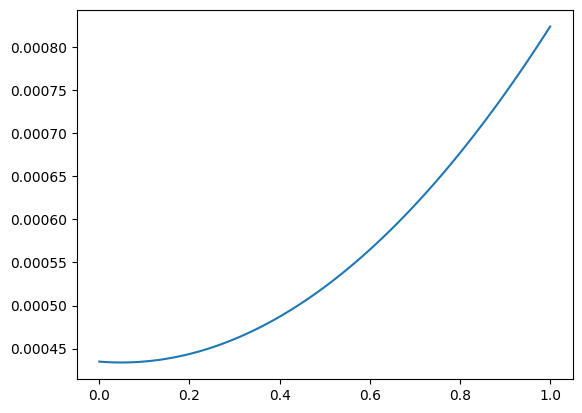

In [206]:
mu_hat = x.mean(axis=0)
T = x.shape[0]
tol = np.minimum(1e-10, 1.0 / np.sqrt(T))
h = 1/x.shape[1]
def L(phi): return h*h*np.array([ np.linalg.norm(x[j+1,:] - geodesic(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()

plt.plot(domain,[ L(domain[i]) for i in range(domain.shape[0])])
from scipy.optimize import minimize

u = np.random.rand()
L(0) - L(phi), minimize(L, 0, method='Nelder-Mead', bounds=[(0,1)], options=dict(xatol=tol))['x'][0]


(array([39.,  1.,  0.,  6., 11., 10., 12.,  9.,  9.,  3.]),
 array([0.        , 0.01882385, 0.0376477 , 0.05647155, 0.0752954 ,
        0.09411925, 0.11294309, 0.13176694, 0.15059079, 0.16941464,
        0.18823849]),
 <BarContainer object of 10 artists>)

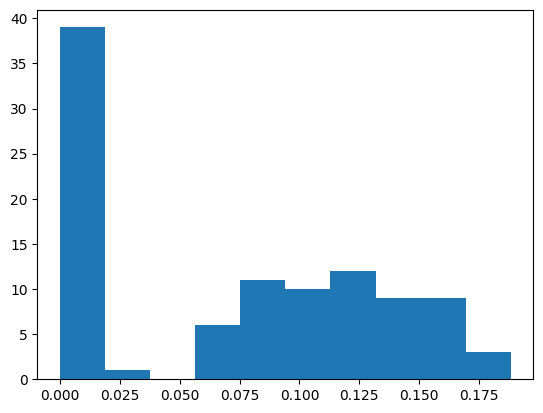

In [82]:
plt.hist(o)

# R with multiplicative noise

In [2]:
def m(x, theta, mu):
    return theta * x + (1-theta)*mu

def sim(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        x[i] = m(x[i-1], theta, mu) + sig*np.random.randn()
    return x

def sim_mul(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        x[i] = (1 + sig*np.random.randn()) * m(x[i-1], theta, mu)
    return x


def sim_sin(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)
        z = m(x[i-1], theta, mu)
        x[i] = z - np.sin(np.pi*k*z)/np.pi/k
    return x

In [12]:
def compute_AutoDist(d):
    # Input:
    #   d: n by n distance matrix, the (i,j)-component denotes the distance d(yi,yj) between yi and yj
    # Output:
    #   Ax, Ay: U-centered versions of the auto-distance matrix
    n = d.shape[0]
    num_k = n - 4
    Ax = np.zeros((n, n, num_k))
    Ay = np.zeros((n, n, num_k))
    
    for k in range(num_k):
        dx = d[(k+1):n, (k+1):n]
        dy = d[:(n-k-1), :(n-k-1)]
        
        Ax[:(n-k-1), :(n-k-1), k] = dx - np.outer(np.sum(dx, axis=1) / (n-k-2), np.sum(dx, axis=0) / (n-k-2)) + np.sum(dx) / ((n-k-1) * (n-k-2))
        Ay[:(n-k-1), :(n-k-1), k] = dy - np.outer(np.sum(dy, axis=1) / (n-k-2), np.sum(dy, axis=0) / (n-k-2)) + np.sum(dy) / (((n-k-1)) * (n-k-2))
        
        np.fill_diagonal(Ax[:(n-k-1), :(n-k-1), k], 0)
        np.fill_diagonal(Ay[:(n-k-1), :(n-k-1), k], 0)

    return Ax, Ay

def prop_test(d, B=500):
    n = d.shape[0]
    num_k = n - 4
    zeta = np.arange(0, np.pi, 0.01)
    rep_CM = np.zeros(B)
    rep_KS = np.zeros(B)

    Ax, Ay = compute_AutoDist(d)
    
    Sn = np.sum(Ax * Ay, axis=(0, 1)) / (n - np.arange(1, num_k + 1) - 3) / (np.arange(1, num_k + 1) * np.pi)
    Sn = Sn @ np.sin(np.outer(np.arange(1, num_k + 1), zeta))

    stat_CM = np.mean(Sn**2) * np.pi
    stat_KS = np.max(np.abs(Sn))

    for b in range(B):
        order_b = np.random.permutation(n)
        Ax_b, Ay_b = compute_AutoDist(d[order_b, :][:, order_b])
        
        Sn_b = np.sum(Ax_b * Ay_b, axis=(0, 1)) / (n - np.arange(1, num_k + 1) - 3) / (np.arange(1, num_k + 1) * np.pi)
        Sn_b = Sn_b @ np.sin(np.outer(np.arange(1, num_k + 1), zeta))

        rep_CM[b] = np.mean(Sn_b**2) * np.pi
        rep_KS[b] = np.max(np.abs(Sn_b))

    return stat_CM, rep_CM, stat_KS, rep_KS

T = 100
phi = 0.5

mean = 1.5
noise_var = 0.2

res = []

for i in tqdm(range(100)):
    x = sim_mul(T, phi, noise_var, mean)

    D_mat = np.zeros((T,T))
    for i in range(T):
        for j in range(i+1,T):
            D_mat[i,j] = np.abs(x[i] - x[j])
            D_mat[j,i] = D_mat[i,j]

    res.append(prop_test(D_mat))


100%|██████████| 100/100 [14:44<00:00,  8.85s/it]


In [23]:
rej_CM = 0
rej_KS = 0

for (stat_CM, rep_CM, stat_KS, rep_KS) in res:
    rej_CM += (stat_CM > np.quantile(rep_CM, 1-0.05)) * 1.0
    rej_KS += (stat_KS > np.quantile(rep_KS, 1-0.05)) * 1.0

rej_CM,rej_KS

(77.0, 20.0)

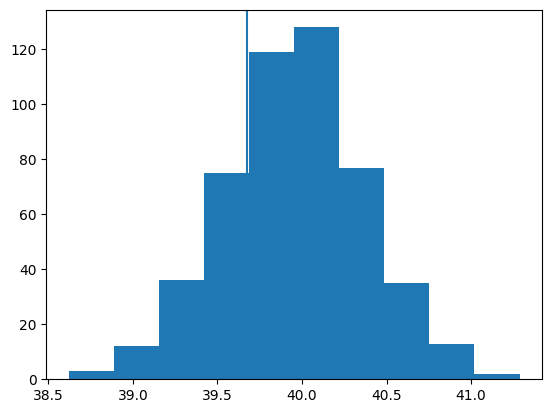

In [8]:
plt.hist(rep_KS)
plt.axvline(stat_KS)

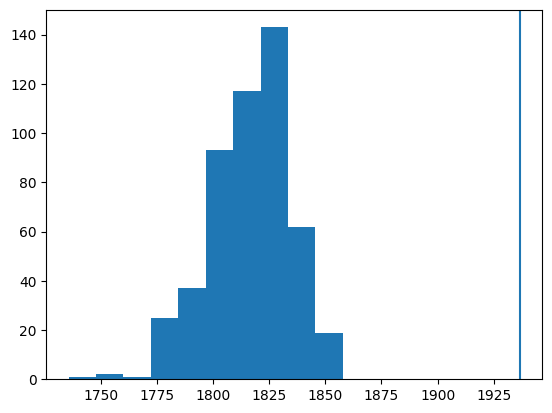

In [9]:
plt.hist(rep_CM)
plt.axvline(stat_CM)

In [7]:
M = 500 # number of replicates
B = 500 # number of bootstrap replicates
S = 0.7 # size of bootstrap sample

phis = [0] #np.linspace(0, 1, 6)
Ts = [200] # [50, 100, 250, 500, 1000, 1200]


df = pd.DataFrame(columns=['T', 'phi', 'replicate_id', 'err_mu_hat', 'phi_hat', 'Dt', 'boot_mean_Dt', 'boot_sig_Dt'])

mean = 1.5
noise_var = 0.2

def phi_hat(x, mu_hat):
    T = x.shape[0]
    grid = np.linspace(0, 1, 40)
    errs = np.zeros_like(grid)
    for i in range(grid.shape[0]): 
        errs[i] = np.array([ (x[j+1] - m(x[j], grid[i], mu_hat))**2 for j in range(T-1) ]).mean()
    return grid[np.argmin(errs)]

def bootstrap_mu_sig(x, B):
    s = int(np.floor(x.shape[0]) * S)
    bootstrap = np.zeros(B)
    for b in range(B):
        permed = np.random.permutation(x)[:s]
        bootstrap[b] = np.mean(np.power(np.diff(permed), 2))
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat


for T in Ts:
    for phi in phis:
        print(f"Running T={T} phi={phi}")
        for replicate_id in tqdm(range(M)):
            x = sim_mul(T, phi, noise_var, mean)

            mu_hat = x.mean()
            # phi_hat_ = phi_hat(x, mu_hat)
            phi_hat_ = 0

            Dt = np.mean(np.power(np.diff(x), 2))

            boot_mean_Dt, boot_sig_Dt = bootstrap_mu_sig(x, B)

            df.loc[len(df)] = [T, phi, replicate_id, (mean - mu_hat)**2, phi_hat_, Dt, boot_mean_Dt, boot_sig_Dt]

# df.to_csv('./results_R_mult_noise_extended.csv')

Running T=200 phi=0


100%|██████████| 500/500 [00:03<00:00, 160.28it/s]


In [8]:
# df_R = pd.read_csv('./results_R_mult_noise.csv')
df_R = df

In [14]:

df['rejected'] =  (np.sqrt(1/S) * np.abs(df_R['Dt'] - df_R['boot_mean_Dt']) / df_R['boot_sig_Dt']) > norm.ppf(0.975)
df.groupby(['T', 'phi']).agg(rejection_rate=('rejected', 'mean')).reset_index()

,T,phi,rejection_rate
0,200.0,0.0,0.004


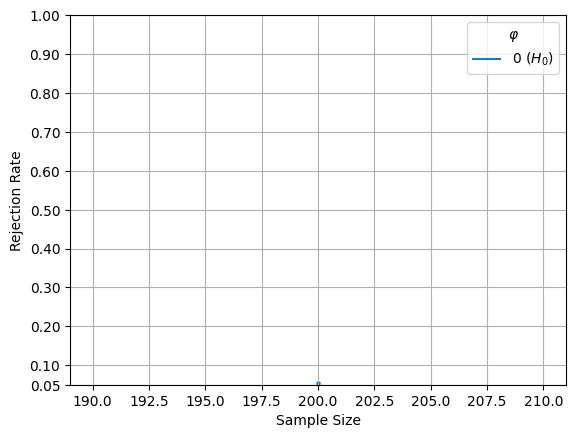

In [5]:
df_R['rejected'] = (np.abs(df_R['Dt'] - df_R['boot_mean_Dt']) / df_R['boot_sig_Dt']) > norm.ppf(0.975)
results = df_R.groupby(['T', 'phi']).agg(rejection_rate=('rejected', 'mean')).reset_index()

# sns.lineplot(results, x='T', y='rejection_rate', hue='phi')


for phi in results.phi.unique():
    sub_df = results[results['phi'] == phi]

    plt.scatter(sub_df['T'], sub_df.rejection_rate, s=5)
    if phi == 0:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=r'$0\ (H_0)$')
    else:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=np.round(phi,1))

plt.xlabel('Sample Size')
plt.ylabel('Rejection Rate')
plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.yticks([0.05,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1]);
# plt.xticks(df['T'].unique())

plt.savefig('./rejection_rates_R_mult_noise.pdf')

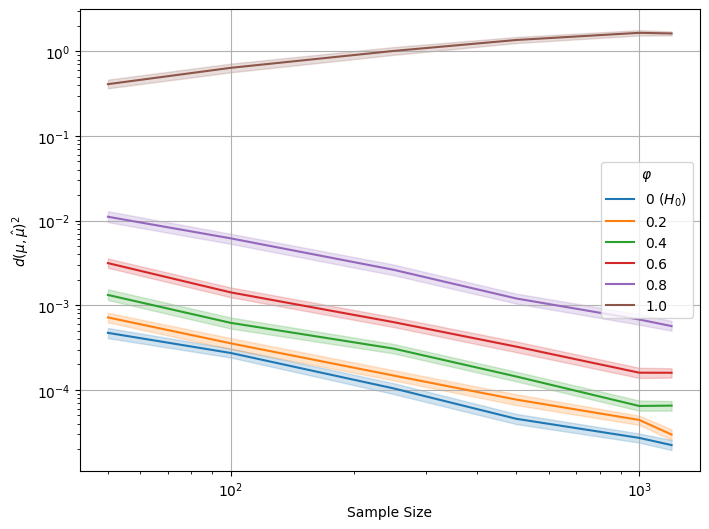

In [277]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in df_R.phi.unique():
    # if phi == 1:
    #     continue
    
    sub_df = df_R[df_R['phi'] == phi]

#     plt.scatter(sub_df['T'], sub_df., s=5)
    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='T', y='err_mu_hat', label=label)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

plt.savefig('./err_mu_R_mult_noise_loglog.pdf')

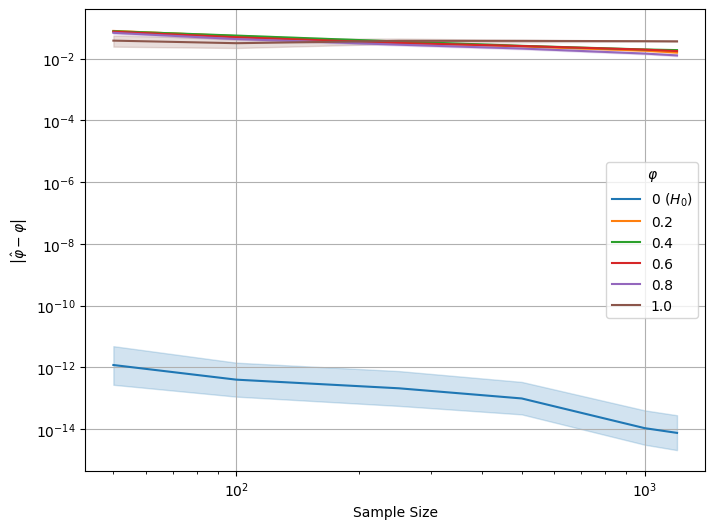

In [284]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in df_R.phi.unique():
    if phi == 0:
        # ax.plot([], [], label=r'$0\ (H_0)$')
        continue
    sub_df = df_R[df_R['phi'] == phi].copy()
    sub_df['err_phi_hat'] = np.abs(sub_df['phi_hat'] - phi) + 1e-20

#     plt.scatter(sub_df['T'], sub_df., s=5)
    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='T', y='err_phi_hat', label=label, ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')

plt.savefig('./err_phi_R_mult_noise.pdf')

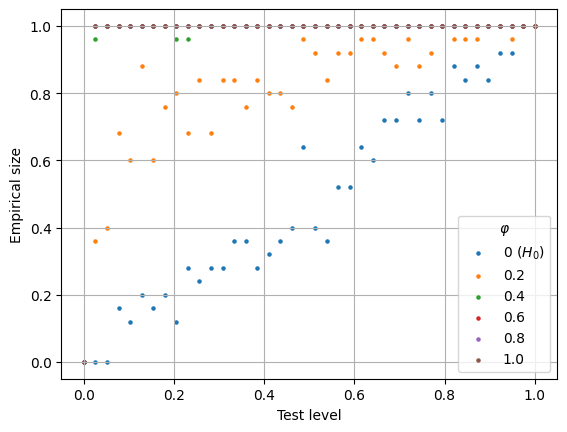

In [290]:
target_T = 100
true_size = np.linspace(0, 1, 40)

for phi in np.sort(df_R['phi'].unique()):
    sub_df = df_R[(df_R['T'] == target_T) & (df_R['phi'] == phi)].copy()
    _M = sub_df.shape[0]

    rejection_rate = (np.repeat((np.abs(sub_df['Dt'] - sub_df['boot_mean_Dt']) / sub_df['boot_sig_Dt']).values,true_size.shape[0]).reshape((true_size.shape[0], _M)) > np.repeat(norm.ppf(1 - true_size/2), _M).reshape((true_size.shape[0], _M))).mean(axis=1)

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    plt.scatter(true_size, rejection_rate, label=label, s=5)
plt.legend(title=r'$\varphi$')
plt.xlabel('Test level')
plt.ylabel('Empirical size')
plt.grid('on')
plt.savefig('./size_rej_rate_R_mult_noise.pdf')


100%|██████████| 1000/1000 [00:14<00:00, 70.89it/s]

% rejects under H1 1.0
% rejects under H0 0.062


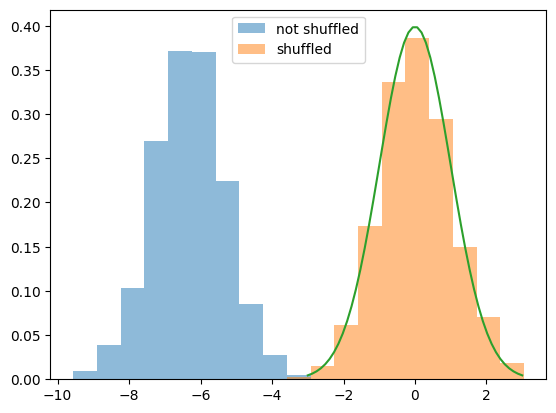

In [9]:
res = np.zeros((1000, 4))

mu = 1.5
theta = 0.2

N = 1_000
B = 500

def bootstrap_mu_sig(x, B):
    # DIRECT ESTIMATION - check this a bit more
    #
    # D_XY_XZ = np.zeros((2, B))
    # for b in range(B):
    #     idx = np.random.randint(N, size=3)
    #     D_XY_XZ[0, b] = np.abs(x[idx[0]] - x[idx[1]])
    #     D_XY_XZ[1, b] = np.abs(x[idx[0]] - x[idx[2]])

    # cov = np.cov(D_XY_XZ)
    # sig_hat = np.sqrt(cov[0,0] + 2*cov[0,1]) / np.sqrt(B)
    # mu_hat = D_XY_XZ[0,:].mean()

    # BOOTSTRAP VERSION
    # 
    bootstrap = np.zeros(B)
    for b in range(B):
        permed = np.random.permutation(x)
        # bootstrap[b] = np.mean(np.abs(np.diff(permed)))
        bootstrap[b] = np.mean(np.power(np.diff(permed), 2))
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat

for i in tqdm(range(res.shape[0])):
    x = sim_mul(N, theta, 0.13, mu)
    
    # res[i,0] = np.mean(np.abs(np.diff(x)))
    res[i,0] = np.mean(np.power(np.diff(x), 2))

    permed = np.random.permutation(x)
    # res[i,1] =  np.mean(np.abs(np.diff(permed)))
    res[i,1] = np.mean(np.power(np.diff(permed), 2))

    mu_hat, sig_hat = bootstrap_mu_sig(x, B)
    res[i, 2] = mu_hat
    res[i, 3] = sig_hat

plt.hist((res[:, 0] - res[:, 2]) / res[:, 3], label='not shuffled', alpha=0.5, density=True)
plt.hist((res[:, 1] - res[:, 2]) / res[:, 3], label='shuffled', alpha=0.5, density=True)

_x = np.linspace(-3, 3)
plt.plot(_x, norm.pdf(_x))

print("% rejects under H1", (np.abs((res[:, 0] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())
print("% rejects under H0", (np.abs((res[:, 1] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())

plt.legend()


# Wasserstein

In [ ]:
def gamma(x, theta, mu):
    # the rvs are represented as their quantile functions, so interpolation is euclidean
    return theta * x + (1-theta)*mu

def sim(N, theta, mu):
    x = np.zeros((N, mu.shape[0])) + mu
    for i in range(1,N):
        z = gamma(x[i-1], theta, mu)

        k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)
        x[i, :] = z - np.sin(np.pi*k*z)/np.pi/abs(k)
    return x

M = 1000 # number of replicates
B = 500 # number of bootstrap replicates

phis = np.linspace(0, 1, 6)
Ts = [50, 100, 250, 500, 1000, 1200]
# Ts = [100, 500, 1000]

df = pd.DataFrame(columns=['T', 'phi', 'replicate_id', 'err_mu_hat', 'phi_hat', 'Dt', 'boot_mean_Dt', 'boot_sig_Dt'])

STD_NORMAL_Q = stats.norm.ppf(W1d.Wasserstein1D.GRID)
STD_NORMAL_Q[0] = 2*STD_NORMAL_Q[1] - STD_NORMAL_Q[2] # lexp to avoid infs
STD_NORMAL_Q[-1] = 2*STD_NORMAL_Q[-2] - STD_NORMAL_Q[-3] # lexp to avoid infs
mean = STD_NORMAL_Q

def phi_hat(x, mu_hat):
    T = x.shape[0]
    W = W1d.Wasserstein1D()

    grid = np.linspace(0, 1, 40)

    def calc(phi): return np.array([ W._d(x[j+1,:], gamma(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
    errs = np.array([ calc(phi) for phi in grid ])
    
    return grid[np.argmin(errs)]

def bootstrap_mu_sig(x, B):
    bootstrap = np.zeros(B)
    for b in range(B):
        permed = np.random.permutation(np.arange(x.shape[0]))
        bootstrap[b] = np.array([ W._d(x[permed[j],:], x[permed[j+1],:])**2 for j in range(T-1) ]).mean()
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat


for T in Ts:
    for phi in phis:
        print(f"Running T={T} phi={phi}")
        for replicate_id in tqdm(range(M)):
            x = sim(T, phi, mean)

            W = W1d.Wasserstein1D()
            mu_hat = MetricData(W, x).frechet_mean()

            phi_hat_ = phi_hat(x, mu_hat)

            Dt = np.array([ W._d(x[j,:], x[j+1,:])**2 for j in range(T-1) ]).mean()
            
            boot_mean_Dt, boot_sig_Dt = bootstrap_mu_sig(x, B)

            df.loc[len(df)] = [T, phi, replicate_id, W._d(mean, mu_hat)**2, phi_hat_, Dt, boot_mean_Dt, boot_sig_Dt]

        df.to_csv('./results_wasserstein_full.csv')

In [286]:
df_W = pd.read_csv('./results_wasserstein_merged.csv')
df_W['phi'] = df_W['phi'].map({ 0.6: 0.6000000000000001 }).fillna(df_W['phi'])

# filenames = ['87395_results_wasserstein_full.csv', '86982_results_wasserstein_full.csv', '83198_results_wasserstein_full.csv', '80721_results_wasserstein_full.csv', '66778_results_wasserstein_full.csv', '55485_results_wasserstein_full.csv', '48339_results_wasserstein_full.csv', '3576_results_wasserstein_full.csv', '8423_results_wasserstein_full.csv', '41221_results_wasserstein_full.csv', '82802_results_wasserstein_full.csv', '89859_results_wasserstein_full.csv']

# df = pd.read_csv('./results_wasserstein_full.csv')
# for filename in filenames:
#     df = pd.concat([df, pd.read_csv(filename)])
# df.to_csv('results_wasserstein_merged.csv')

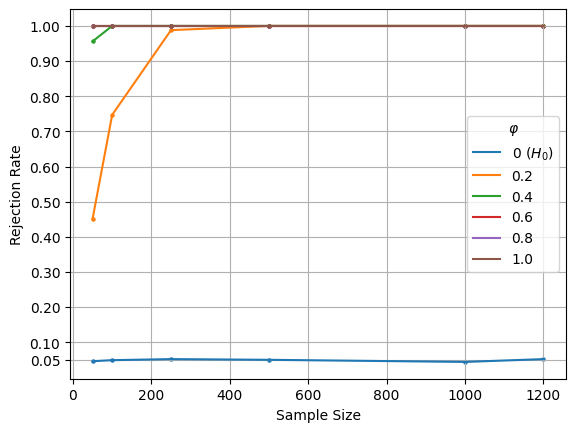

In [239]:
df_W['rejected'] = (np.abs(df_W['Dt'] - df_W['boot_mean_Dt']) / df_W['boot_sig_Dt']) > norm.ppf(0.975)
results = df_W.groupby(['T', 'phi']).agg(rejection_rate=('rejected', 'mean')).reset_index()

# sns.lineplot(results, x='T', y='rejection_rate', hue='phi')


for phi in results.phi.unique():
    sub_df = results[results['phi'] == phi]

    plt.scatter(sub_df['T'], sub_df.rejection_rate, s=5)
    if phi == 0:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=r'$0\ (H_0)$')
    else:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=np.round(phi,1))

plt.xlabel('Sample Size')
plt.ylabel('Rejection Rate')
plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.yticks([0.05,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1]);
# plt.xticks(df['T'].unique())

plt.savefig('./rejection_rates_wasserstein.pdf')

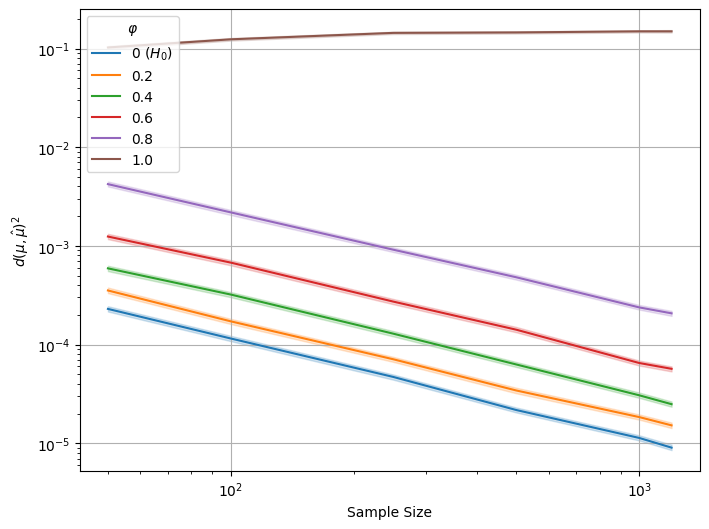

In [272]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in df_W.phi.unique():
    sub_df = df_W[df_W['phi'] == phi]
    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='T', y='err_mu_hat', label=label, ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

plt.savefig('./err_mu_wasserstein.pdf')

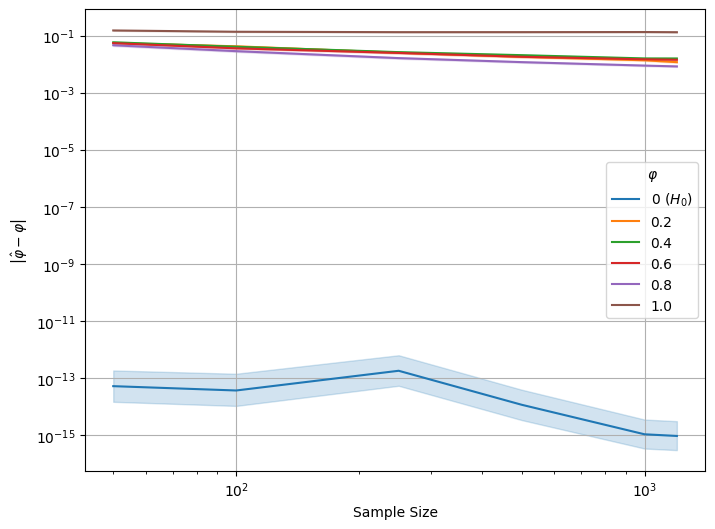

In [287]:
fig, ax = plt.subplots(figsize=(8,6))
# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
# fig.subplots_adjust(hspace=0.05)  # adjust space between axes
# ax1.set(xscale="log", yscale="log")
# ax2.set(xscale="log", yscale="log")
ax.set(xscale="log", yscale="log")

for phi in df_W.phi.unique():
    # if phi == 0:
    #     continue
    sub_df = df_W[df_W['phi'] == phi].copy()
    sub_df['err_phi_hat'] = np.abs(sub_df['phi_hat'] - phi) + 1e-20
    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='T', y='err_phi_hat', label=label, ax=ax)
    # if phi == 0:
    #     # continue
    #     sns.lineplot(sub_df, x='T', y='err_phi_hat', label=np.round(phi,1), ax=ax2)
    # else:
    #     sns.lineplot(sub_df, x='T', y='err_phi_hat', label=np.round(phi,1), ax=ax1)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')

# ax1.spines.bottom.set_visible(False)
# ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
# ax2.xaxis.tick_bottom()

# d = .5  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


plt.savefig('./err_phi_wasserstein.pdf')

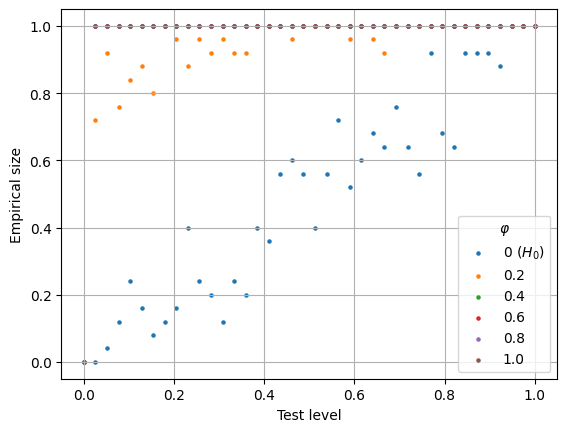

In [291]:
target_T = 100
true_size = np.linspace(0, 1, 40)

for phi in np.sort(df_W['phi'].unique()):
    sub_df = df_W[(df_W['T'] == target_T) & (df_W['phi'] == phi)].copy()
    _M = sub_df.shape[0]

    rejection_rate = (np.repeat((np.abs(sub_df['Dt'] - sub_df['boot_mean_Dt']) / sub_df['boot_sig_Dt']).values,true_size.shape[0]).reshape((true_size.shape[0], _M)) > np.repeat(norm.ppf(1 - true_size/2), _M).reshape((true_size.shape[0], _M))).mean(axis=1)

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    plt.scatter(true_size, rejection_rate, label=label, s=5)

plt.legend(title=r'$\varphi$')
plt.xlabel('Test level')
plt.ylabel('Empirical size')
plt.grid('on')
plt.savefig('./size_rej_rate_wasserstein.pdf')


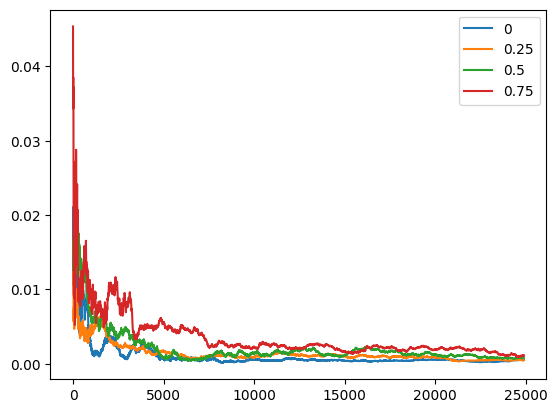

In [316]:


def gamma(x, theta, mu):
    # the rvs are represented as their quantile functions, so interpolation is euclidean
    return theta * x + (1-theta)*mu

def sim(N, theta, mu):
    x = np.zeros((N, mu.shape[0])) + mu
    for i in range(1,N):
        z = gamma(x[i-1], theta, mu)

        k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)
        x[i, :] = z - np.sin(np.pi*k*z)/np.pi/abs(k)
    return x

STD_NORMAL_Q = stats.norm.ppf(W1d.Wasserstein1D.GRID)
STD_NORMAL_Q[0] = 2*STD_NORMAL_Q[1] - STD_NORMAL_Q[2] # lexp to avoid infs
STD_NORMAL_Q[-1] = 2*STD_NORMAL_Q[-2] - STD_NORMAL_Q[-3] # lexp to avoid infs


N = 25_000
thetas = [0, 0.25, 0.5, 0.75]
mu = STD_NORMAL_Q

for j in range(len(thetas)):
    theta = thetas[j]
    x = sim(N, theta, mu)

    M = W1d.Wasserstein1D()

    mu_hats = np.zeros_like(x)
    errs = np.zeros(N)
    for i in range(2,N):
        mu_hats[i,:] = MetricData(M, x[:i,:]).frechet_mean()
        errs[i] = M.d(mu, mu_hats[i,:])

    plt.plot(errs[100:], label=theta)

plt.legend()


100%|██████████| 100/100 [00:01<00:00, 52.22it/s]


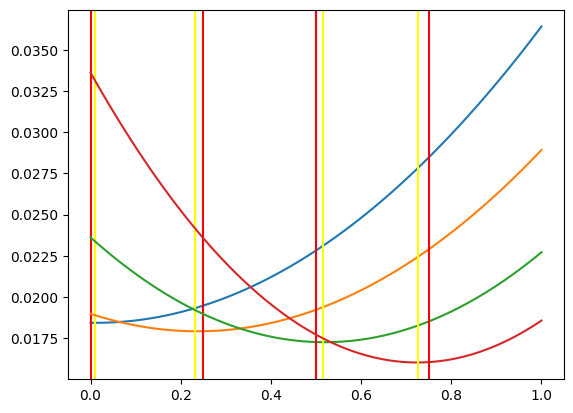

In [318]:
tgrid = np.linspace(0,1,100)

N = 1_000
thetas = [0, 0.25, 0.5, 0.75]
mu = STD_NORMAL_Q

for j in range(len(thetas)):
    theta = thetas[j]
    x = sim(N, theta, mu)

    M = W1d.Wasserstein1D()
    mu_hat = MetricData(M, x).frechet_mean()
    def calc(_theta): return np.array([ M._d(gamma(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, N) ]).mean()

    errs = np.array([ calc(tgrid[i]) for i in tqdm(range(tgrid.shape[0])) ])
    plt.plot(tgrid, errs, label=theta)
    plt.axvline(theta, color='red', label=theta)
    plt.axvline(tgrid[np.argmin(errs)], color='yellow', label=theta)



# tgrid = np.linspace(0,1,100)
# def calc(_theta): return np.array([ M._d(gamma(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, N) ]).mean()
# errs = np.array([ calc(tgrid[i]) for i in tqdm(range(tgrid.shape[0])) ])

# plt.plot(tgrid, errs)
# plt.axvline(theta, color='red')
# plt.axvline(tgrid[np.argmin(errs)], color='yellow')

100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it]

% rejects under H1 1.0
% rejects under H0 0.054


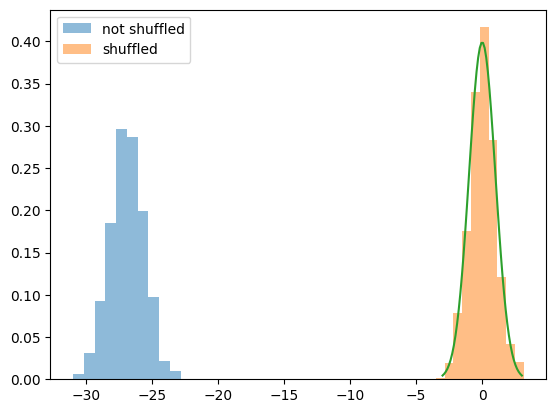

In [303]:
def Dn(x):
    # faster to do by hand to get vectorization
    return np.sqrt(np.sum(np.power(np.diff(x, axis=0), 2), axis=1)).mean() * np.sqrt(W1d.Wasserstein1D.GRID[1] - W1d.Wasserstein1D.GRID[0])

def bootstrap_mu_sig(x, B):
    # DIRECT ESTIMATION - check this a bit more
    #
    # D_XY_XZ = np.zeros((2, B))
    # for b in range(B):
    #     idx = np.random.randint(N, size=3)
    #     D_XY_XZ[0, b] = np.abs(x[idx[0]] - x[idx[1]])
    #     D_XY_XZ[1, b] = np.abs(x[idx[0]] - x[idx[2]])

    # cov = np.cov(D_XY_XZ)
    # sig_hat = np.sqrt(cov[0,0] + 2*cov[0,1]) / np.sqrt(B)
    # mu_hat = D_XY_XZ[0,:].mean()

    # BOOTSTRAP VERSION
    # 

    # def boot():
    #     return Dn(np.random.permutation(x))

    # bootstrap = np.array(Parallel(n_jobs=-1)(delayed(boot)() for i in range(B)))

    bootstrap = np.zeros(B)
    for b in range(B):
        bootstrap[b] = Dn(np.random.permutation(x))
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat


res = np.zeros((1000, 4))

N = 1_000
B = 1_000

theta = 0.5
mu = STD_NORMAL_Q

for i in tqdm(range(res.shape[0])):
    x = sim(N, theta, mu)
    
    res[i,0] = Dn(x)

    permed = np.random.permutation(x)
    res[i,1] = Dn(permed)

    mu_hat, sig_hat = bootstrap_mu_sig(x, B)
    res[i, 2] = mu_hat
    res[i, 3] = sig_hat

plt.hist((res[:, 0] - res[:, 2]) / res[:, 3], label='not shuffled', alpha=0.5, density=True)
plt.hist((res[:, 1] - res[:, 2]) / res[:, 3], label='shuffled', alpha=0.5, density=True)

_x = np.linspace(-3, 3)
plt.plot(_x, norm.pdf(_x))

print("% rejects under H1", (np.abs((res[:, 0] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())
print("% rejects under H0", (np.abs((res[:, 1] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())

plt.legend()

